IMPORTLIB

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler,StandardScaler,PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

#deep modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import GridSearchCV


LOADING_DATASET

In [2]:
df = pd.read_csv("data_prj/housing.csv")
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Preprocessing

In [3]:
df.shape

(20640, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [6]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [7]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


ENCODING

In [8]:
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9034
INLAND        6496
NEAR OCEAN    2628
NEAR BAY      2270
ISLAND           5
Name: count, dtype: int64

In [9]:
df = df.join(pd.get_dummies(df['ocean_proximity'])).drop(['ocean_proximity'], axis = 1)
df = df.astype({col: 'int' for col in df.select_dtypes(include='bool').columns})
df['rooms_per_household'] = df['total_rooms'] / df['households']
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
df['population_per_household'] = df['population'] / df['households']
# Đổi tên cột loại bỏ ký tự đặc biệt
df.columns = df.columns.str.replace(r"[<>\[\]]", "_", regex=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 20433 non-null  float64
 1   latitude                  20433 non-null  float64
 2   housing_median_age        20433 non-null  float64
 3   total_rooms               20433 non-null  float64
 4   total_bedrooms            20433 non-null  float64
 5   population                20433 non-null  float64
 6   households                20433 non-null  float64
 7   median_income             20433 non-null  float64
 8   median_house_value        20433 non-null  float64
 9   _1H OCEAN                 20433 non-null  int32  
 10  INLAND                    20433 non-null  int32  
 11  ISLAND                    20433 non-null  int32  
 12  NEAR BAY                  20433 non-null  int32  
 13  NEAR OCEAN                20433 non-null  int32  
 14  rooms_per_h

In [10]:
df.corr()['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688355
_1H OCEAN                   0.257614
NEAR BAY                    0.160526
rooms_per_household         0.151344
NEAR OCEAN                  0.140378
total_rooms                 0.133294
housing_median_age          0.106432
households                  0.064894
total_bedrooms              0.049686
ISLAND                      0.023525
population_per_household   -0.023639
population                 -0.025300
longitude                  -0.045398
latitude                   -0.144638
bedrooms_per_room          -0.255880
INLAND                     -0.484787
Name: median_house_value, dtype: float64

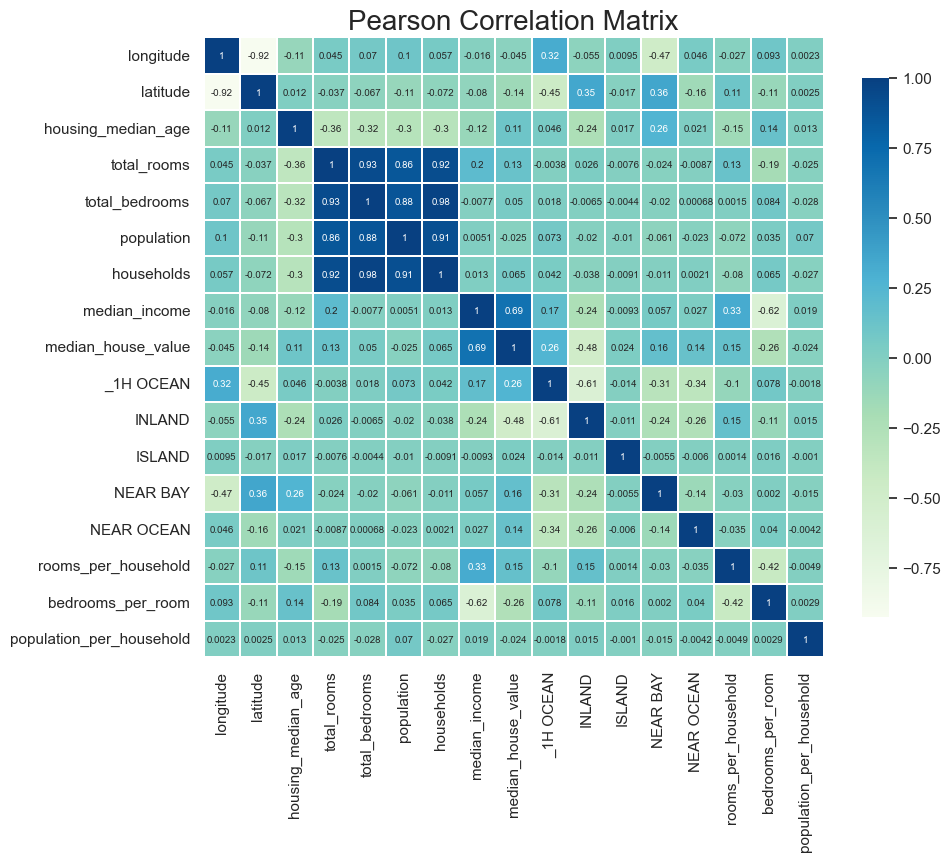

In [11]:
# Đặt phong cách và tỷ lệ font
sns.set(style="whitegrid", font_scale=1)

# Tạo figure với kích thước phù hợp
plt.figure(figsize=(10, 10))

# Tiêu đề cho biểu đồ
plt.title('Pearson Correlation Matrix', fontsize=20)

# Vẽ heatmap cho ma trận tương quan của DataFrame df
sns.heatmap(df.corr(), 
            linewidths=0.25,        # Độ dày của đường viền giữa các ô
            vmax=1,                 # Giới hạn tối đa của màu sắc (đạt giá trị tối đa 1 cho tương quan hoàn hảo)
            square=True,            # Chuyển heatmap thành hình vuông
            cmap="GnBu",            # Màu sắc của heatmap
            linecolor='w',          # Màu sắc của đường viền ô
            annot=True,             # Hiển thị giá trị tương quan trong từng ô
            annot_kws={"size": 7},  # Kích thước font cho các giá trị tương quan
            cbar_kws={"shrink": 0.7}) # Thu nhỏ thanh màu

# Hiển thị biểu đồ
plt.show()


TỪ ĐỒ THỊ TRÊN, TA CÓ THỂ CHỌN RA CÁC FEATURE CÓ ĐỘ ẢNH HƯỞNG ĐẾN GIÁ CAO ĐỂ HUẤN LUYỆN

In [12]:
threshold = 0.1
important_features = []
ocean_proximity = ["_1H OCEAN","INLAND","ISLAND","NEAR BAY", "NEAR OCEAN"]

features_corr = df.corr()['median_house_value']
for col in features_corr.index:
    if col != 'median_house_value' and col not in ocean_proximity and abs(features_corr[col]) > threshold:
        important_features.append(col)
for col in ocean_proximity:
    important_features.append(col)
important_features

['latitude',
 'housing_median_age',
 'total_rooms',
 'median_income',
 'rooms_per_household',
 'bedrooms_per_room',
 '_1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN']

TRAIN_TEST_SPLIT + SCALE

In [13]:
scale = PowerTransformer()
X_ann = df[important_features]
X_ann = scale.fit_transform(X_ann)
y = df['median_house_value']
y_ann = np.log1p(y)
x_train_ann, x_test_ann, y_train_ann, y_test_ann = train_test_split(X_ann, y_ann, test_size=0.3, random_state=42)

MODEL_TRAINING

ANN

In [14]:
model = Sequential([
    Dense(1024, input_dim=x_train_ann.shape[1], activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(500, activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(120, activation='relu', kernel_regularizer='l2'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation='linear')  # Dự đoán giá trị liên tục
])

# Compile mô hình
model.compile(
    optimizer=Adam(),
    loss='mean_squared_error',
    metrics=['mae']
)

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [16]:
history = model.fit(
    x_train_ann, y_train_ann,
    validation_data=(x_test_ann, y_test_ann),
    epochs=200, 
    batch_size=256,
    callbacks=[es, reduce_lr],
    verbose=1
)

Epoch 1/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 151.7284 - mae: 11.8832 - val_loss: 130.9366 - val_mae: 11.0457 - learning_rate: 0.0010
Epoch 2/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 124.8762 - mae: 10.7286 - val_loss: 92.8093 - val_mae: 9.1944 - learning_rate: 0.0010
Epoch 3/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 80.8587 - mae: 8.3954 - val_loss: 42.3284 - val_mae: 5.8821 - learning_rate: 0.0010
Epoch 4/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 36.5804 - mae: 5.0817 - val_loss: 14.7059 - val_mae: 2.5905 - learning_rate: 0.0010
Epoch 5/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 15.6504 - mae: 2.4588 - val_loss: 7.0693 - val_mae: 0.6610 - learning_rate: 0.0010
Epoch 6/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 10.5734 - mae: 1.6265 - val_loss: 8.2144 - val_mae: 0.3588 - learning_rate: 0.0010
Epoch 7/200
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 10.0729 - mae: 1.5183 - val_loss: 5.3079 - val_mae: 0.4106 - learning_ra

In [17]:

def plot_predictions(y_test, y_pred):
    # Đổi thành array và flatten
    y_test = np.array(y_test).flatten()
    y_pred = np.array(y_pred).flatten()
    # Sắp xếp các giá trị theo y_test
    sorted_indices = np.argsort(y_test)  # Chỉ số sắp xếp theo y_test
    y_test_sorted = y_test[sorted_indices]  # Sắp xếp y_test
    y_pred_sorted = y_pred[sorted_indices]  # Sắp xếp y_pred tương ứng
    
    # Tạo trục x theo số thứ tự sau khi sắp xếp
    x = np.arange(len(y_test_sorted))  # Trục x chính xác
    
    # Vẽ đồ thị
    plt.figure(figsize=(80, 6))
    plt.plot(x, y_test_sorted, label="Giá trị thật (y_test)", color="blue", linewidth=2)
    plt.plot(x, y_pred_sorted, label="Giá trị dự đoán (y_pred)", color="red", linestyle="dashed", linewidth=2)
    plt.xlabel("Mẫu dữ liệu (sắp xếp theo y_test)")
    plt.ylabel("Giá trị")
    plt.title("So sánh giá trị thật và dự đoán")
    plt.legend()
    plt.grid(True)
    plt.show()


192/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


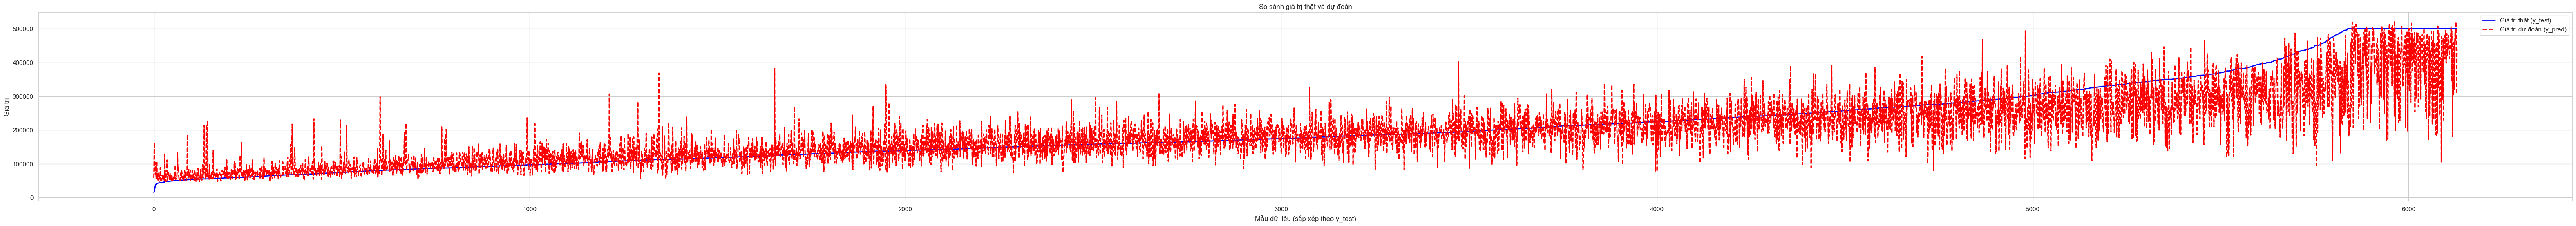

In [18]:
y_pred_ann = model.predict(x_test_ann)
y_pred_original = np.expm1(y_pred_ann)  # Chuyển đổi lại giá trị từ log-transform
y_test_original = np.expm1(y_test_ann)  # Chuyển đổi lại giá trị từ log-transform
plot_predictions(y_test_original,y_pred_original)

In [19]:
mse = mean_squared_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

Mean Squared Error: 3886509116.4609394
R² Score: 0.70845931935692


RF

SPLIT

In [20]:
scale_rf = StandardScaler()
X_RF = df.drop('median_house_value',axis = 1)
X_RF = scale_rf.fit_transform(X_RF)
x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(X_RF, y, test_size=0.3, random_state=42)


GRID

In [21]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=42, bootstrap=True)
param_grid = {
    'n_estimators': [250, 400],            # Số lượng cây trong rừng
    'max_features': [0.6, 0.8],            # Tỉ lệ số đặc trưng được sử dụng
    'max_depth': [10,20,None],             # Độ sâu tối đa của cây
    'max_samples': [0.8,1],                # Tỉ lệ mẫu được chọn cho mỗi cây
    'min_samples_split': [5,10],           # Số mẫu tối thiểu để phân chia một node
    'min_samples_leaf': [5,10]             # Số mẫu tối thiểu tại node lá
}

In [22]:
rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    verbose=2,
    n_jobs=-1,
    return_train_score=True
)
rf_grid.fit(x_train_rf, y_train_rf)
print(f"Best params: {rf_grid.best_params_}")
print(f"Best score: {rf_grid.best_score_}")
y_best_rf_pred = rf_grid.best_estimator_.predict(x_test_rf)
mse = mean_squared_error(y_test_rf, y_best_rf_pred)
mae = mean_absolute_error(y_test_rf, y_best_rf_pred)
r2 = r2_score(y_test_rf, y_best_rf_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best params: {'max_depth': None, 'max_features': 0.6, 'max_samples': 0.8, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 250}
Best score: 0.8096409830144923
Mean Squared Error (MSE): 2497911210.92832
Mean Absolute Error (MAE): 32929.207889467245
R² Score: 0.8126229187175661


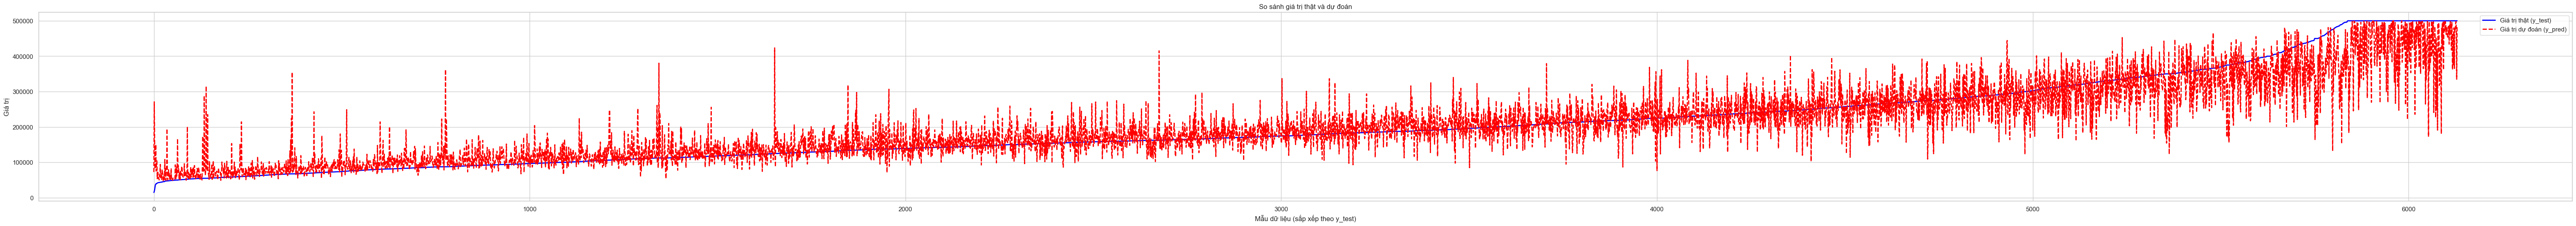

In [23]:
plot_predictions(y_test_rf, y_best_rf_pred)

XGBOOST

IMPORT

In [24]:
import xgboost as xgb

DATA

In [25]:
scale_xg = MinMaxScaler()
df.columns = df.columns.astype(str)
X_xg = df.drop(columns=["median_house_value"])
X_xg = scale_xg.fit_transform(X_xg)
X_train_xg, X_test_xg, y_train_xg, y_test_xg = train_test_split(X_xg, y, test_size=0.2, random_state=42)

BUILD MODEL

In [26]:
xgb_regressor = xgb.XGBRegressor(
    objective="reg:squarederror",
    eval_metric="rmse"
)

param_grid = {
    "max_depth": [6, 7, 8, 9, 10],
    "learning_rate": [0.05],
    "subsample": [0.6,0.8,0.9,1],
    "colsample_bytree": [0.8],
    "n_estimators": [100, 200, 300, 400, 500]
}

grid_search = GridSearchCV(
    estimator=xgb_regressor,
    param_grid=param_grid,
    scoring='neg_mean_squared_error', 
    cv=5,  
    verbose=2, 
    n_jobs=-1,  
    refit=True  
)

grid_search.fit(X_train_xg, y_train_xg)

print(f"Best parameters found: {grid_search.best_params_}")

best_model = grid_search.best_estimator_

y_pred_xg = best_model.predict(X_test_xg)

mae = mean_absolute_error(y_test_xg, y_pred_xg)
mse = mean_squared_error(y_test_xg, y_pred_xg)
r2 = r2_score(y_test_xg, y_pred_xg)

print(f"Best Model Performance: MAE={mae}, MSE={mse}, R2={r2}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.9}
Best Model Performance: MAE=28851.636997836125, MSE=1992994459.582889, R2=0.8542619296399997


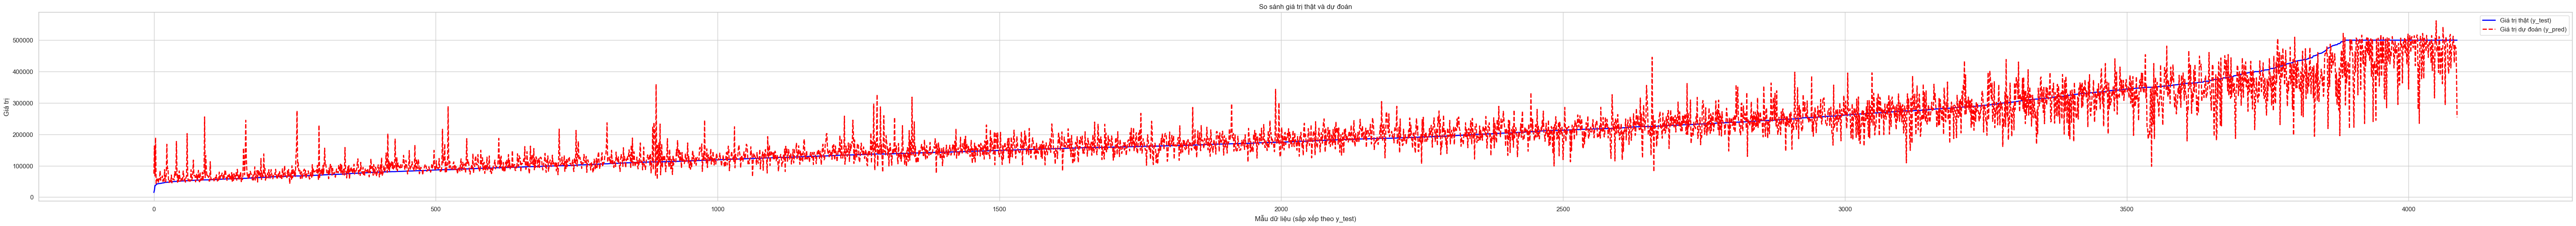

In [27]:

plot_predictions(y_test_xg, y_pred_xg)

PREDICTIVE SYSTEM

Do XGBoost có độ chính xác cao nhất nên ta sẽ sử dụng mô hình để dự đoán 

In [28]:
def pred(longitude, latitude, housing_median_age, total_rooms, total_bedrooms, population, households, median_income, ocean_proximity):
    # Mapping ocean_proximity sang giá trị số (nếu đã dùng map)
    ocean_mapping = {
    "<1H OCEAN": [1, 0, 0, 0, 0],
    "INLAND": [0, 1, 0, 0, 0],
    "NEAR OCEAN": [0, 0, 1, 0, 0],
    "NEAR BAY": [0, 0, 0, 1, 0],
    "ISLAND": [0, 0, 0, 0, 1],
}
    
    
    # Lấy danh sách dummy tương ứng
    ocean_dummies = ocean_mapping[ocean_proximity]


    # Kết hợp tất cả đặc trưng vào một danh sách
    input_features = [
        longitude, latitude, housing_median_age, total_rooms, total_bedrooms,
        population, households, median_income
    ] + ocean_dummies
    rooms_per_household = total_rooms / households
    bedrooms_per_room = total_bedrooms / total_rooms
    population_per_household = population / households
    input_features += [rooms_per_household, bedrooms_per_room, population_per_household]

    # Biến đổi thành numpy array
    input_features = np.array(input_features).reshape(1, -1)
    input_features = scale_xg.transform(input_features)

    # Dự đoán
    prediction = best_model.predict(input_features)
    return prediction[0]
    print(input_features)


In [29]:
pred(-122.25,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,"NEAR BAY") #452600.0

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


432922.4

SAVING MODEL

In [30]:
import pickle

pickle.dump(best_model, open("best_xgboost_model.pkl", "wb"))
pickle.dump(scale_xg,open("scaler.pkl","wb"))

